In [158]:
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cobra.flux_analysis import single_gene_deletion
from molmass import Formula

%matplotlib inline

In [159]:
model=cobra.io.read_sbml_model("D:/Genomes/Lk_iPN730n.xml")
model.solver='glpk'
model.reactions.EX_cpd00092_e0.bounds=(0,1000)
model.reactions.EX_cpd19013_e0.bounds=(-1000,1000)
model.reactions.EX_cpd00027_e0.bounds=(-2.28,1000)
model.reactions.EX_cpd00007_e0.bounds=(-10,1000)
model.summary()

'M_abt-L_e' is not a valid SBML 'SId'.
'M_abt-L_c' is not a valid SBML 'SId'.
'M_lald-L_c' is not a valid SBML 'SId'.
'M_trp-L_m' is not a valid SBML 'SId'.
'M_trp-L_c' is not a valid SBML 'SId'.
'M_trp-L_e' is not a valid SBML 'SId'.
'M_asn-L_c' is not a valid SBML 'SId'.
'M_asn-L_e' is not a valid SBML 'SId'.
'M_tyr-L_p' is not a valid SBML 'SId'.
'M_arab-D_c' is not a valid SBML 'SId'.
'M_arab-D_e' is not a valid SBML 'SId'.
'M_tyr-L_m' is not a valid SBML 'SId'.
'M_tyr-L_v' is not a valid SBML 'SId'.
'M_tyr-L_e' is not a valid SBML 'SId'.
'M_tyr-L_c' is not a valid SBML 'SId'.
'M_glu-L_e' is not a valid SBML 'SId'.
'M_glu-L_n' is not a valid SBML 'SId'.
'M_glu-L_m' is not a valid SBML 'SId'.
'M_glc-D_v' is not a valid SBML 'SId'.
'M_glu-L_c' is not a valid SBML 'SId'.
'M_glc-D_c' is not a valid SBML 'SId'.
'M_glc-D_e' is not a valid SBML 'SId'.
'M_glu-L_p' is not a valid SBML 'SId'.
'M_manmi1p-D_c' is not a valid SBML 'SId'.
'M_glu-L_v' is not a valid SBML 'SId'.
'M_phe-L_m' is not

In [7]:
bio=model.reactions.get_by_id('bio1')
met_pc=bio.metabolites
met_names=[]
met_coeff=[]
met_formula=[]
met_chemnames=[]
for met in met_pc:
    met_names.append(met.id)
    met_coeff.append(met_pc[met])
    met_chemnames.append(met.name)
    met_formula.append(met.formula)
met_formula[1]='C4140H7644O1300P100'
met_formula[9]='C3736H7172N100O1000P100'
met_formula[10]='C3636H7172N100O800P100'

In [23]:
def cnratio(modelg):
    nh4=np.linspace(0.1,2.27,20)
    cn=((6*2.26)/(1*nh4)*(12/14))
    fit=[]
    for n in nh4:
        modelg.reactions.EX_cpd19013_e0.bounds=(-n,1000)
        fit.append(modelg.slim_optimize())
    cnval=cn[fit.index(max(fit))]
    return [cnval,max(fit)]

In [24]:
def gr(p,metc,metn):
    if(metc<0):
        
        #Increase
        modelf=model.copy()
        biof=modelf.reactions.get_by_id('bio1')
        biof.add_metabolites({modelf.metabolites.get_by_id(metn):p*(-metc)})
        gr_plus10=modelf.slim_optimize()
        sgd_minimal=single_gene_deletion(model,method='FBA')
        sgd_minimal['SimulationTruth']=sgd_minimal['growth'].apply(lambda x:'Growth' if (round(x,5)!=0) else 'No Growth')
        ess_genp10=sgd_minimal[sgd_minimal['SimulationTruth']=='No Growth'].count()['growth']
        
#         optgr_p10=cnratio(modelf)
        
        #Decrease
        modelf=model.copy()
        biof=modelf.reactions.get_by_id('bio1')
        biof.add_metabolites({modelf.metabolites.get_by_id(metn):p*(metc)})
        gr_minus10=modelf.slim_optimize()
        sgd_minimal=single_gene_deletion(model,method='FBA')
        sgd_minimal['SimulationTruth']=sgd_minimal['growth'].apply(lambda x:'Growth' if (round(x,5)!=0) else 'No Growth')
        ess_genm10=sgd_minimal[sgd_minimal['SimulationTruth']=='No Growth'].count()['growth']
        #         optgr_m10=cnratio(modelf)
        
        return gr_plus10,gr_minus10,ess_genp10,ess_genm10

In [277]:
def atomcount(formula,e):
    f=Formula(formula)
    get=list(f.composition())
    d=pd.DataFrame(get,columns=['Element','Count','Bla1','Bla2'])
    d.index=d['Element']
    return d['Count'][e]

In [27]:
p=50
p=p/100
p10=[]
m10=[]
ess_p10=[]
ess_m10=[]
print("Metabolite","\t","C/N(-10%)","\t","Growth Rate","\t","C/N(+10%)","Growth Rate","\t""\n")
for metn,metc in zip(met_names,met_coeff):
    print('Current Biomass Precursor: ',metn)
    grp10,grm10,essp10,essm10=gr(p,metc,metn)
    p10.append(grp10)
    m10.append(grm10)
    ess_p10.append(essp10)
    ess_m10.append(essm10)
    print('Increase-Growth Rate: ',grp10)
    print('Decrease-Growth Rate: ',grm10)
    print('Increase-Essential Genes: ',essp10)
    print('Decrease-Essential Genes: ',essm10)

Metabolite 	 C/N(-10%) 	 Growth Rate 	 C/N(+10%) Growth Rate 	

Current Biomass Precursor:  13BDglcn_c
Increase-Growth Rate:  0.23480462916939426
Decrease-Growth Rate:  0.20746642149173244
Increase-Essential Genes:  119
Decrease-Essential Genes:  119
Current Biomass Precursor:  M_ptd1ino_SC_c_c0
Increase-Growth Rate:  0.22094068155334767
Decrease-Growth Rate:  0.2196443202153938
Increase-Essential Genes:  119
Decrease-Essential Genes:  119
Current Biomass Precursor:  ala-L_c
Increase-Growth Rate:  0.22255930622127765
Decrease-Growth Rate:  0.21806766779169204
Increase-Essential Genes:  119
Decrease-Essential Genes:  119
Current Biomass Precursor:  amp_c
Increase-Growth Rate:  0.22125469099033007
Decrease-Growth Rate:  0.21933486189332105
Increase-Essential Genes:  119
Decrease-Essential Genes:  119
Current Biomass Precursor:  arg-L_c
Increase-Growth Rate:  0.22250738609151427
Decrease-Growth Rate:  0.2181175364221303
Increase-Essential Genes:  119
Decrease-Essential Genes:  119
Current

TypeError: cannot unpack non-iterable NoneType object

In [296]:
df_sorted=pd.DataFrame({"Name":pd.Series(met_chemnames[:44]),"Increase":p10,"Decrease":m10,"Formula":met_formula[:44],'Coeff':met_coeff[:44]})
df_sorted['Diff']=df_sorted['Increase']-df_sorted['Decrease']
df_sorted['Formula']=df_sorted['Formula'].apply(lambda x: x[0:x.index('R')] if ('R' in x) else x)
df_sorted=df_sorted.sort_values(by='Diff',ascending=False)
df_sorted=df_sorted.reset_index(drop=True)

In [297]:
#CountC/NRatio
df_sorted['C']=df_sorted['Formula'].apply(lambda x:(atomcount(x,'C')) if ('C' in x) else 0)
df_sorted['N']=df_sorted['Formula'].apply(lambda x:(atomcount(x,'N')) if ('N' in x) else 0)
df_sorted['Cmols']=df_sorted['C']*abs(df_sorted['Coeff'])
df_sorted['Nmols']=df_sorted['N']*abs(df_sorted['Coeff'])

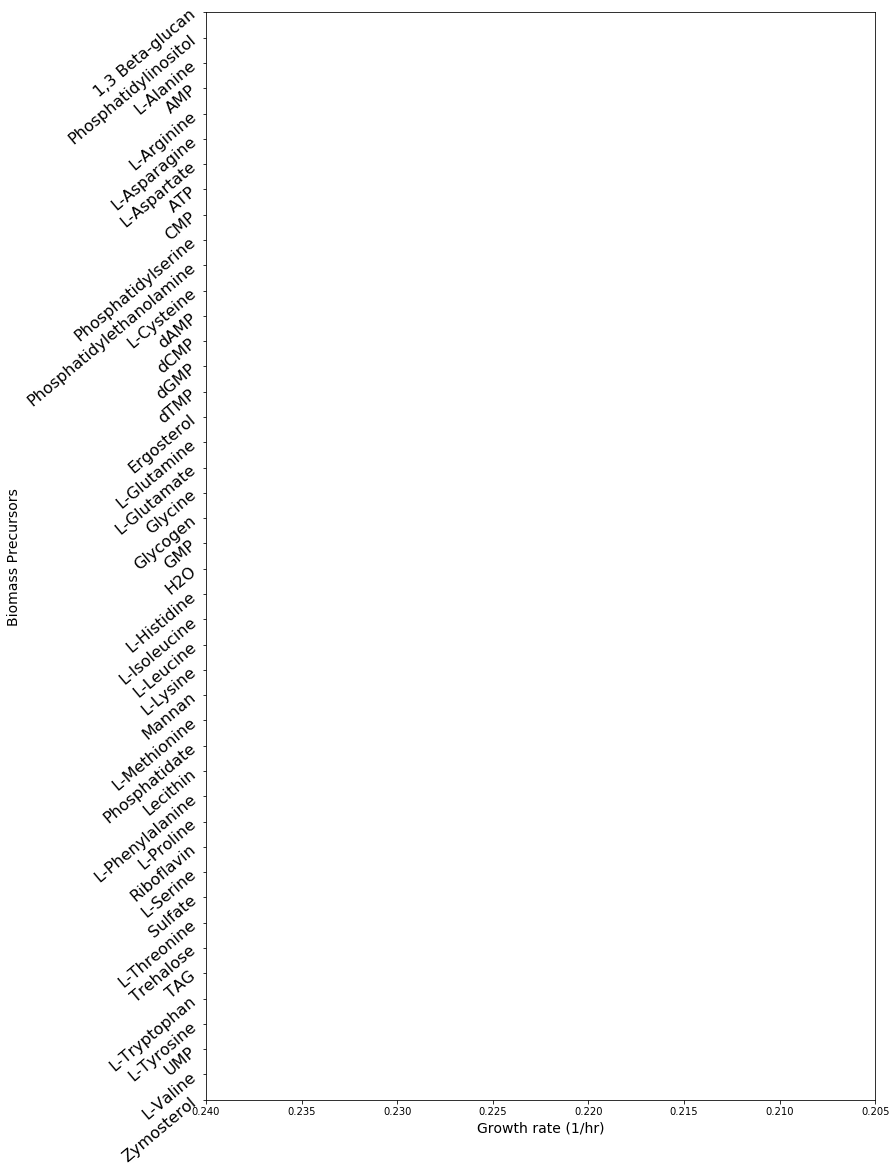

In [33]:
import matplotlib.ticker as ticker
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(12,20))
ax.bar(df_sorted['Name'],df_sorted['Diff'],bottom=df_sorted['Decrease'],color='r')
ax.set_ylabel('Biomass Precursors',fontsize=14)
ax.set_xlabel('Growth rate (1/hr)',fontsize=14)
ax.set_xlim([0.205,0.24])
plt.yticks(np.arange(0,44,1),rotation=40)
ax.set_yticklabels(met_chemnames,fontsize=16)
ax.plot(df_sorted['Increase'],'bo')
ax.plot(df_sorted['Decrease'],'yo')
plt.gca().invert_xaxis()

In [34]:
fig.savefig("D:/ScientificReports/BiomassSensitivityNames.jpg",dpi=1200)

In [311]:
df_sorted['CmolsInc']=df_sorted['Cmols']*1.5
df_sorted['CmolsDec']=df_sorted['Cmols']*0.5
df_sorted['NmolsInc']=df_sorted['Nmols']*1.5
df_sorted['NmolsDec']=df_sorted['Nmols']*0.5

df_sorted['C/NInc']=pd.Series()
df_sorted['C/NDec']=pd.Series()

for i in range(len(df_sorted)):
    df_sorted['C/NInc'][i]=(df_sorted['Cmols'].sum()+(df_sorted['CmolsInc'][i]-df_sorted['Cmols'][i]))/(df_sorted['Nmols'].sum()+(df_sorted['NmolsInc'][i]-df_sorted['Nmols'][i]))
    df_sorted['C/NDec'][i]=(df_sorted['Cmols'].sum()+(df_sorted['Cmols'][i]-df_sorted['CmolsDec'][i]))/(df_sorted['Nmols'].sum()+(df_sorted['Nmols'][i]-df_sorted['NmolsDec'][i]))
    

C:\Users\Piyush\Anaconda3\lib\site-packages\ipykernel_launcher.py:10 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Piyush\Anaconda3\lib\site-packages\ipykernel_launcher.py:11 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [312]:
df_sorted

,Name,Increase,Decrease,Formula,Coeff,Diff,C,N,Cmols,Nmols,CmolsInc,CmolsDec,NmolsInc,NmolsDec,C/NInc,C/NDec
0,1_3_beta_Glucan,2.348046e-01,0.207466,C18H32O16,-1.134800,0.027338,18,0,20.426400,0.00000,30.639600,10.213200,0.00000,0.00000,2.232211,2.232211
1,Mannan,2.304311e-01,0.211005,C18H32O16,-0.807900,0.019426,18,0,14.542200,0.00000,21.813300,7.271100,0.00000,0.00000,2.222468,2.222468
2,Glycogen,2.266931e-01,0.214240,C30H52O26,-0.518500,0.012453,30,0,15.555000,0.00000,23.332500,7.777500,0.00000,0.00000,2.224145,2.224145
3,L_Leucine,2.243658e-01,0.216361,C6H13NO2,-0.296400,0.008005,6,1,1.778400,0.29640,2.667600,0.889200,0.44460,0.14820,2.200254,2.200254
4,L_Lysine,2.243402e-01,0.216385,C6H15N2O2,-0.286200,0.007956,6,2,1.717200,0.57240,2.575800,0.858600,0.85860,0.28620,2.199148,2.199148
5,L_Isoleucine,2.230477e-01,0.217601,C6H13NO2,-0.192700,0.005447,6,1,1.156200,0.19270,1.734300,0.578100,0.28905,0.09635,2.199602,2.199602
6,L_Phenylalanine,2.229292e-01,0.217714,C9H11NO2,-0.133900,0.005216,9,1,1.205100,0.13390,1.807650,0.602550,0.20085,0.06695,2.199897,2.199897
7,L_Valine,2.229116e-01,0.217731,C5H11NO2,-0.264600,0.005181,5,1,1.323000,0.26460,1.984500,0.661500,0.39690,0.13230,2.199616,2.199616
8,L_Glutamate,2.227722e-01,0.217864,C5H8NO4,-0.301800,0.004909,5,1,1.509000,0.30180,2.263500,0.754500,0.45270,0.15090,2.199789,2.199789
9,L_Alanine,2.225593e-01,0.218068,C3H7NO2,-0.458800,0.004492,3,1,1.376400,0.45880,2.064600,0.688200,0.68820,0.22940,2.198998,2.198998


In [316]:
cobra.io.write_sbml_model(model,"D:/ScientificReports/iPN730.xml")